In [85]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import seaborn as sns
import matplotlib.pyplot as plt

# Zadanie

Dysponujesz danymi z portalu Our World in Data dotyczącymi:
- Pierwotnej konsumpcji energii
- Emisji CO2 z poszczególnych lat dla różnych krajów

## Część 1: Plik CSV
Utwórz plik CSV zawierający połączone dane dla Polski:
- konsumpcja energii pierwotnej
- emisja CO2
- dane z poszczególnych lat

## Część 2: Plik Excel
Stwórz plik Excel z osobnymi zakładkami dla każdego kraju:
- UE
- USA
- Chiny
- Indie

Każda zakładka powinna zawierać dane o konsumpcji energii i emisji CO2.

## Część 3: Baza danych SQLite
Utwórz bazę danych SQLite z tabelą zawierającą:
- kraj
- rok
- emisja CO2
- konsumpcja energii

Dane powinny obejmować: Polskę, Niemcy i Hiszpanię.

## Część 4: Analiza i wizualizacja
Na podstawie danych z pliku Excel i bazy SQLite utwórz wykresy:
- emisja CO2 w zależności od roku (dla wybranego kraju)
- konsumpcja energii pierwotnej w zależności od roku (dla wybranego kraju)
- **dla chęnych szukanie koreacji**

In [86]:
#Wspólne
df_co2 = pd.read_csv('co2-emissions-per-capita.csv')
df_primary_energy = pd.read_csv('primary-energy-cons.csv')
conn = sqlite3.connect('mydata.sqlite')

def prepare_data(entity):
  co2_filtered = df_co2[df_co2['Entity'] == entity]
  energy_filtered = df_primary_energy[df_primary_energy['Entity'] == entity].drop('Code', axis=1)
  return pd.merge(co2_filtered, energy_filtered, how='outer')

def create_sheet(workbook, sheet_name, frame):
  sheet = workbook.create_sheet(sheet_name)
  rows = dataframe_to_rows(frame)
  for r_idx, row in enumerate(rows, 1):
    for c_idx, value in enumerate(row, 1):
      sheet.cell(row=r_idx, column=c_idx, value=value)


In [87]:
#Część 1
co2_energy_poland = prepare_data('Poland')
co2_energy_poland.to_csv('co2-and-energy-poland.csv')

In [88]:
#Część 2
wb = openpyxl.Workbook()
del wb['Sheet']

for country in ['European Union (27)', 'United States', 'China', 'India']:
  co2_and_energy_country = prepare_data(country)
  create_sheet(wb, country, co2_and_energy_country)

wb.save('co2-and-energy-per-country.xlsx')


In [89]:
#Część 3
drop_query = "DROP TABLE CO2_AND_ENERGY;"
conn.execute(drop_query)
conn.commit()
create_query = """
  CREATE TABLE CO2_AND_ENERGY
  (
    COUNTRY VARCHAR(50),
    YEAR VARCHAR(4),
    CO2_EMISSION REAL,
    ENERGY_CONSUMPTION REAL
  );
"""
conn.execute(create_query)
conn.commit()

insert_query = "INSERT INTO CO2_AND_ENERGY VALUES(?, ?, ?, ?)"

for country in ['Poland', 'Germany', 'Spain']:
  co2_energy_country = prepare_data(country)
  conn.executemany(insert_query, co2_energy_country.values.tolist())

conn.commit()

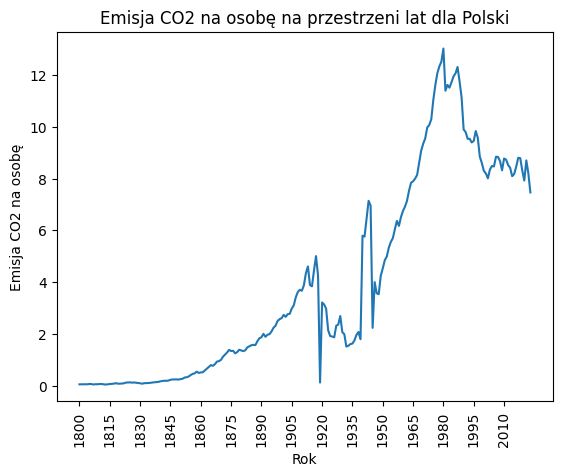

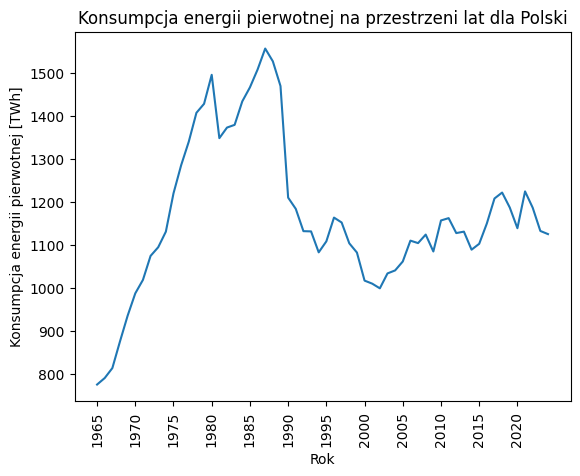

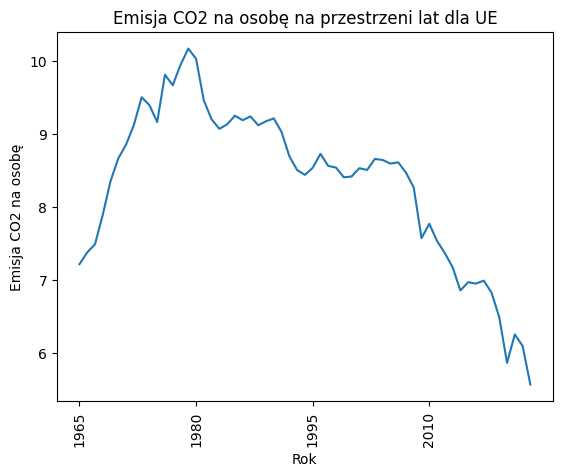

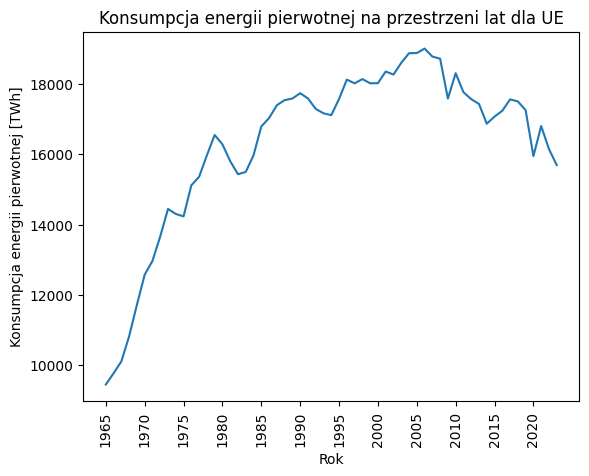

In [90]:
#Część 4
cursor = conn.execute('SELECT * FROM CO2_AND_ENERGY WHERE COUNTRY = "Poland"')
rows = cursor.fetchall()
database_data = pd.DataFrame(rows, columns=['country', 'year', 'co2_emission', 'energy_consumption'])
sns.lineplot(data=database_data, x='year', y='co2_emission')
plt.title('Emisja CO2 na osobę na przestrzeni lat dla Polski')
plt.xlabel('Rok')
plt.ylabel('Emisja CO2 na osobę')
plt.xticks(database_data["year"][::15], rotation = 'vertical')
plt.show()
database_data = database_data.dropna(subset=['energy_consumption'])
sns.lineplot(data=database_data, x='year', y='energy_consumption')
plt.title('Konsumpcja energii pierwotnej na przestrzeni lat dla Polski')
plt.xlabel('Rok')
plt.ylabel('Konsumpcja energii pierwotnej [TWh]')
plt.xticks(database_data["year"][::5], rotation = 'vertical')
plt.show()

excel_data = pd.read_excel('co2-and-energy-per-country.xlsx','European Union (27)')
excel_data = excel_data.dropna()
sns.lineplot(data=excel_data, x='Year', y='Annual CO₂ emissions (per capita)')
plt.title('Emisja CO2 na osobę na przestrzeni lat dla UE')
plt.xlabel('Rok')
plt.ylabel('Emisja CO2 na osobę')
plt.xticks(excel_data["Year"][::15], rotation = 'vertical')
plt.show()
sns.lineplot(data=excel_data, x='Year', y='Primary energy consumption (TWh)')
plt.title('Konsumpcja energii pierwotnej na przestrzeni lat dla UE')
plt.xlabel('Rok')
plt.ylabel('Konsumpcja energii pierwotnej [TWh]')
plt.xticks(excel_data["Year"][::5], rotation = 'vertical')
plt.show()